In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm

In [2]:
# MKT res每日收益率平均值
res = (ff.read('close')*ff.read('post')).pct_change(1,axis = 1)
MKT = (res * ff.filter0).mean()

In [11]:
MKT.sum()

1.6456479815829463

In [4]:
#市值因子收益率  样本空间中市值收益率最小的1/3股票构建的流通市值加权组合与最大1/3股票组合收益率之差
#最小的1/3市值收益率-最大的1/3市值收益率(total_mv)
#市值规模
mv = ff.read('total_mv') * ff.filter0
mvS = (mv <= mv.quantile(0.5)).replace({True:1,False:np.nan}) #必须 replace否则会导致 mean计算错误和出现 0收益率的情况被错误替换成 nan
mvB = (mv > mv.quantile(0.5)).replace({True:1,False:np.nan})
#账面市值比 市净值的倒数(1/PB)
pb = ff.read('pb') * ff.filter0
pbH = (pb <= pb.quantile(1/3)).replace({True:1,False:np.nan})
pbM = ((pb > pb.quantile(1/3)) & (pb <= pb.quantile(2/3))).replace({True:1,False:np.nan})
pbL = (pb > pb.quantile(2/3)).replace({True:1,False:np.nan})

In [5]:
#计算三因子,挑选股票后计算盈利率，求均值
SL = ((mvS * pbL).shift(1,axis=1) * res).mean()
SM = ((mvS * pbM).shift(1,axis=1) * res).mean()
SH = ((mvS * pbH).shift(1,axis=1) * res).mean()
BL = ((mvB * pbL).shift(1,axis=1) * res).mean()
BM = ((mvB * pbM).shift(1,axis=1) * res).mean()
BH = ((mvB * pbH).shift(1,axis=1) * res).mean()
SMB = (SL + SM + SH)/3 - (BL + BM + BH)/3
HML = (BH + SH)/2 - (BL + SL)/2

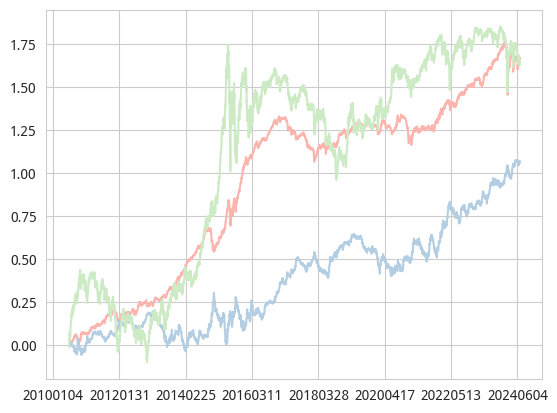

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_style("whitegrid")
sns.set_palette("Pastel1")
mpl.rc("font",family='Droid Sans Fallback',weight="bold")
fig,ax = plt.subplots()
SMB.cumsum().plot()
HML.cumsum().plot()
MKT.cumsum().plot()
plt.show()

In [7]:
IVol = pd.DataFrame(index = ff.rets_all.columns,columns = ff.rets_all.index)
stock_list = range(ff.rets_all.shape[0]-1)
time_list = ff.rets_all.shape[1]
def AHXZ(stock):
    res_single = res.iloc[stock,:]
    data0 = pd.concat([MKT,SMB,HML,res_single],axis = 1)
    data0.columns = ["MKT","SMB","HML","res"]
    for time in range(20,time_list):
        data = data0.fillna(0)[time-20:time] #20天的回归周期
        y = data['res']
        x = np.column_stack((data['MKT'], data['SMB'], data['HML']))
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        IVol.iloc[time,stock] = (model.resid).std()
    return IVol.iloc[:,stock]
from multiprocessing import Pool
from tqdm import tqdm
stock_list = [i for i in range(res.shape[0])]
# stock_list = [i for i in range(100)]
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(AHXZ, stock_list), total=len(stock_list)))
IV = pd.concat(res_lst,axis = 1)
(IV.T).loc[:,'20210818':'20230414']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5548/5548 [08:53<00:00, 10.41it/s]


,20210818,20210819,20210820,20210823,20210824,20210825,20210826,20210827,20210830,20210831,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,0.01683,0.017327,0.016555,0.019618,0.019054,0.019227,0.019422,0.020681,0.020604,0.021671,...,0.009473,0.009667,0.008403,0.008582,0.008556,0.007669,0.007122,0.007199,0.0072,0.007688
000002.SZ,0.019642,0.019725,0.019727,0.020374,0.018896,0.018396,0.019904,0.020152,0.020062,0.024643,...,0.007797,0.009438,0.008917,0.009617,0.009622,0.014627,0.014606,0.015293,0.01528,0.015345
000004.SZ,0.033551,0.033824,0.032676,0.033517,0.029456,0.029587,0.029089,0.029382,0.032444,0.031915,...,0.010068,0.010258,0.011084,0.011781,0.01186,0.012666,0.012381,0.012332,0.012251,0.012151
000005.SZ,0.016478,0.016162,0.015448,0.01259,0.012145,0.011743,0.015473,0.015371,0.015284,0.019185,...,0.005561,0.005757,0.006134,0.005533,0.005582,0.005351,0.005154,0.00532,0.005357,0.005109
000006.SZ,0.009522,0.00942,0.008775,0.008809,0.008329,0.008283,0.008393,0.00854,0.009949,0.010042,...,0.015062,0.013139,0.012737,0.012057,0.012666,0.01381,0.012658,0.013199,0.013518,0.013348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873706.BJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873726.BJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873806.BJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873833.BJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


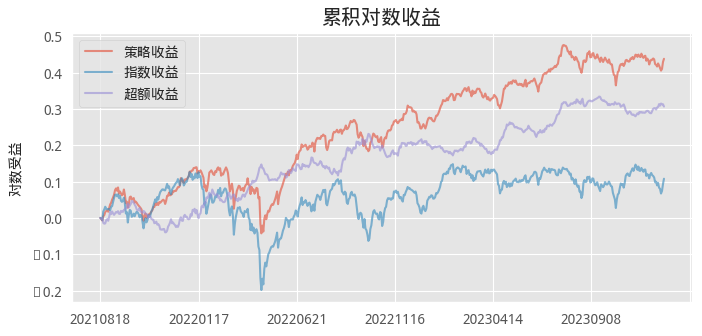

,指数收益,超额收益,策略收益
年化收益率,0.047,0.133,0.191
年化波动率,0.191,0.094,0.157
夏普率,0.246,1.425,1.218
最大回撤,-0.325,-0.086,-0.182
收益回撤比,0.144,1.546,1.046
胜率,0.541,0.508,0.563
盈亏比,0.882,1.217,0.954


(        指数收益   超额收益   策略收益
 年化收益率  0.047  0.133  0.191
 年化波动率  0.191  0.094  0.157
 夏普率    0.246  1.425  1.218
 最大回撤  -0.325 -0.086 -0.182
 收益回撤比  0.144  1.546  1.046
 胜率     0.541  0.508  0.563
 盈亏比    0.882  1.217  0.954,
                 策略     index          策略收益      指数收益      超额收益
 20210818  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20210819  0.996038  0.998393 -3.970329e-03 -0.001608 -0.002359
 20210820  0.992871  0.993688 -7.154924e-03 -0.006332 -0.000827
 20210823  1.004386  1.017875  4.376168e-03  0.017717 -0.013651
 20210824  1.007620  1.023405  7.590806e-03  0.023135 -0.015867
 ...            ...       ...           ...       ...       ...
 20231225  1.511188  1.083465  4.128958e-01  0.080164  0.309352
 20231226  1.500425  1.069433  4.057485e-01  0.067129  0.315164
 20231227  1.507732  1.077197  4.106066e-01  0.074362  0.312772
 20231228  1.536712  1.097582  4.296453e-01  0.093110  0.313068
 20231229  1.550048  1.113982  4.382856e-01  0.107941  0.306784
 
 [575

In [9]:
ff.run(IV.T*ff.filter0.loc[:,'20210818':'20240101'], positions = 100, period = 1, fees = 0) 

In [118]:
IVol = pd.DataFrame(index = ff.rets_all.columns,columns = ff.rets_all.index)
stock_list = range(ff.rets_all.shape[0]-1)
time_list = ff.rets_all.shape[1]
def AHXZ(stock):
    res_single = res.iloc[stock,:]
    data0 = pd.concat([MKT,SMB,HML,res_single],axis = 1)
    data0.columns = ["MKT","SMB","HML","res"]
    for time in range(20,time_list):
        data = data0.fillna(0)[time-20:time] #20天的回归周期
        y = data['res']
        x = np.column_stack((data['MKT'], data['SMB'], data['HML']))
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        IVol.iloc[time,stock] = 1-model.rsquared
    return IVol.iloc[:,stock]
from multiprocessing import Pool
from tqdm import tqdm
stock_list = [i for i in range(res.shape[0])]
# stock_list = [i for i in range(100)]
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(AHXZ, stock_list), total=len(stock_list)))
IVR = pd.concat(res_lst,axis = 1)
(IVR.T).loc[:,'20210818':'20230414']

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5526/5526 [03:30<00:00, 26.24it/s]


,20210818,20210819,20210820,20210823,20210824,20210825,20210826,20210827,20210830,20210831,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,0.377112,0.345922,0.315858,0.386086,0.46675,0.624956,0.642714,0.633073,0.64347,0.656501,...,0.571685,0.605957,0.527744,0.561028,0.57193,0.551861,0.464295,0.459276,0.490921,0.631202
000002.SZ,0.392866,0.389076,0.3836,0.396666,0.489538,0.66857,0.751529,0.721739,0.720077,0.7449,...,0.510489,0.669563,0.61336,0.759523,0.755587,0.778375,0.817261,0.820294,0.824899,0.809613
000004.SZ,0.65256,0.664302,0.658499,0.63572,0.572946,0.587516,0.744654,0.788129,0.945053,0.972663,...,0.555591,0.528705,0.545895,0.474193,0.512964,0.500135,0.468168,0.463695,0.485998,0.480241
000005.SZ,0.85683,0.896126,0.841575,0.727655,0.613501,0.65868,0.803533,0.792007,0.802381,0.89249,...,0.325971,0.316266,0.360205,0.278116,0.314557,0.281873,0.263747,0.282667,0.316443,0.346684
000006.SZ,0.461864,0.449215,0.427801,0.434114,0.49609,0.528462,0.643425,0.669148,0.675594,0.669367,...,0.675493,0.608205,0.676498,0.622029,0.714472,0.694132,0.599007,0.61732,0.687735,0.675256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873703.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873706.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


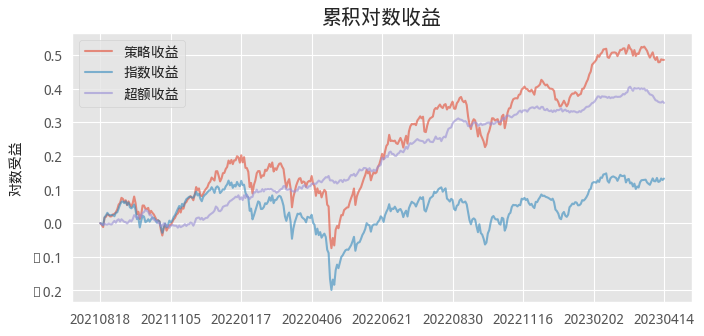

,指数收益,超额收益,策略收益
年化收益率,0.083,0.223,0.303
年化波动率,0.206,0.080,0.234
夏普率,0.400,2.772,1.292
最大回撤,-0.325,-0.054,-0.276
收益回撤比,0.254,4.165,1.096
胜率,0.556,0.566,0.589
盈亏比,0.850,1.186,0.866


(        指数收益   超额收益   策略收益
 年化收益率  0.083  0.223  0.303
 年化波动率  0.206  0.080  0.234
 夏普率    0.400  2.772  1.292
 最大回撤  -0.325 -0.054 -0.276
 收益回撤比  0.254  4.165  1.096
 胜率     0.556  0.566  0.589
 盈亏比    0.850  1.186  0.866,
                 策略     index          策略收益      指数收益      超额收益
 20210818  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20210819  0.994703  0.998393 -5.310898e-03 -0.001608 -0.003697
 20210820  0.988553  0.993688 -1.151349e-02 -0.006332 -0.005169
 20210823  1.016503  1.017875  1.636806e-02  0.017717 -0.001243
 20210824  1.019280  1.023405  1.909654e-02  0.023135 -0.003947
 ...            ...       ...           ...       ...       ...
 20230410  1.613407  1.130490  4.783481e-01  0.122652  0.360431
 20230411  1.613919  1.132385  4.786656e-01  0.124326  0.359072
 20230412  1.627111  1.142069  4.868059e-01  0.132841  0.358694
 20230413  1.625157  1.136951  4.856046e-01  0.128350  0.361969
 20230414  1.624798  1.141728  4.853833e-01  0.132543  0.357537
 
 [401

In [119]:
ff.run(IVR.T*ff.filter0.loc[:,'20210818':'20230414'], positions = 100, period = 1, fees = 0) 

In [117]:
#价格时滞
# def PriceDelay(stock):
res_single = ff.rets_all.iloc[stock,:]
data0 = pd.concat([MKT,res_single],axis = 1)
data0
# res_delay = 
# data0.columns = ["MKT","res"]

,0,000001.SZ
20100104,NaN,NaN
20100105,NaN,NaN
20100106,NaN,NaN
20100107,NaN,NaN
20100108,NaN,NaN
...,...,...
20240305,-0.015635,0.009681
20240306,0.009665,-0.009588
20240307,-0.008046,0.004840
20240308,0.010680,0.000000


In [ ]:
start, end = '20041231', '20151130'
read_data = lambda keyword:((ff.read(keyword) * ff.read('post') * ff.filter0).loc[:, start:end] 
                            if keyword in ('open', 'close', 'high', 'low')
                            else (ff.read(keyword) * ff.filter0).loc[:, start:end])
data_close = read_data('close')
data_close = data_close[data_close.notnull().any(axis = 1)]

In [202]:
#换手率
data_turnover_rate = (ff.read('turnover_rate') * ff.filter0).loc[:, start:end] 
data_turnover_rate = data_turnover_rate[data_turnover_rate.notnull().any(axis = 1)].T
data_turnover_rate.index = pd.to_datetime(data_turnover_rate.index)
data_turnover_rate = data_turnover_rate.resample('m').mean().to_period('m').T
data_turnover_rate.iloc[:,-1]

000001.SZ     0.764533
000002.SZ     0.747905
000004.SZ     4.161257
000005.SZ     8.973838
000006.SZ     4.200167
               ...    
603988.SH    12.390195
603989.SH    15.529147
603993.SH     2.419343
603997.SH    23.303710
603998.SH     9.652619
Name: 2015-11, Length: 2580, dtype: float64

In [123]:
read_data('open')
read_data('high')
read_data('pre_close')

,20100104,20100105,20100106,20100107,20100108,20100111,20100112,20100113,20100114,20100115,...,20151117,20151118,20151119,20151120,20151123,20151124,20151125,20151126,20151127,20151130
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.34,12.50,12.42,12.50,12.55,12.45,12.28,12.32,12.23,11.73
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.00,14.00,14.67,14.50,14.49,14.37,14.50,14.56,14.50,14.26
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.00,36.98,38.64,39.84,41.80,39.50,39.35,40.40,39.98,37.19
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.77,10.54,10.49,10.62,10.41,10.24,10.34,10.58,10.58,9.52
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.00,11.78,11.85,11.92,11.88,11.96,11.88,11.95,12.30,11.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873703.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873833.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
